## LDA on partionally clustered (kmeans) words

In [18]:
from datetime import datetime
import json
import os
import sys

# gensim
import gensim
import gensim.corpora as corpara
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytz
import pickle

# lda plotting tools
import pyLDAvis
import pyLDAvis.gensim

#sklearn
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


# nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords


from time import time
from wordcloud import WordCloud


sys.path.append('../../util')
from database_connector import SQLConnector
from keys_handler import read_local_keys

In [2]:
HOME = os.environ['HOME']
KEYS = f'{HOME}/config/db.json'
ENV = 'dev'
NOW = datetime.utcnow().replace(tzinfo=pytz.utc)
TODAY = NOW.date()

DATA_DIR = '../data'
MODEL_DIR = '../model'
SQL_DIR = '../sql'
OUT_DIR = '../output'

DEV = True

In [3]:
if DEV:
    RUN_DATE = '2020-12-19'
else:
    RUN_DATE = str(NOW.date())
# RUN_DATE = str(NOW.date())
RUN_DATE

'2020-12-19'

#### Load kmeans model

In [6]:
with open(f'{MODEL_DIR}/kmean_ngram.pkl', 'rb') as file:
    kmeans_mod = pickle.load(file)

In [19]:
kmeans_mod

MiniBatchKMeans(batch_size=10000, n_clusters=10, n_init=10)

#### Wordcloud

In [9]:
cmnt_title_ngrams = pd.read_csv(f'{DATA_DIR}/cmnt_title_ngrams.csv')

In [10]:
cmnt_title_ngrams.head()

,ngram,counts,multiplier,n
0,wikipedia org wiki,637,599.508675,3
1,open source,795,557.274270,2
2,org wiki,656,459.838894,2
3,wikipedia org,638,447.221364,2
4,ray tracing,584,409.368772,2


In [11]:
len(cmnt_title_ngrams.ngram)

5428601

In [13]:
cmnt_title_ngrams.ngram.dropna(axis=0, inplace=True)

In [14]:
len(cmnt_title_ngrams.ngram)

5428597

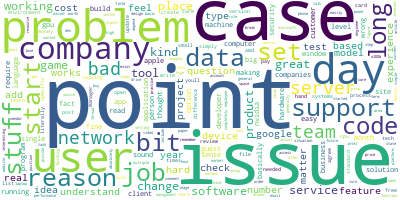

In [15]:
# Join the different ngrams together.
long_string = ','.join(list(cmnt_title_ngrams.ngram.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color='white', 
                      max_words=5000,
                      contour_width=3,
                      contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

In [17]:
wordcloud.to_file(f'{OUT_DIR}/ngram_wordcloud.png')

### Hierarchical clustering

1. First partion the documents (comments & title words) into ___K___ clusters, denoted by $C = \{C_{1}, C_{2},...., C_{k}\}$ using one-level clustering method suck as LDA or SC or kmeans. These are referred to as __top level clusters__

2. For each top level cluster $C_{i}$, if $|C_{i}| > N$, where $|C_{i}|$ denotes the number of words contained in $C_{i}$ , and $N$ is a preset number (for example, $N = 100 words$), then further partition $C_{i}$ into $K_{i}$ sub-clusters as the second level clusters, where $K_{i} = 1 + \frac{|C_{i}|}{N}$

3. If in the new clustering, all but one cluster are empty, then this means that documents in $C_{i}$ cannot be futher divided into sub-topics. In this case, we sort the documents in $C_{i}$ evenly into $K_{i}$ clusters

4. Calculate scores of each document - TODO

5. For a seconf-level cluster $C_{ij}$ of $C_{i}$, if $|C_{ij}| > N$, we may futher create a third-level sub-slutering by clustering $C_{ij}$ 

#### Iterate over paritioned clusters

In [22]:
# for cluster_num, centroid in enumerate(kmeans_mod.cluster_centers_):
#     print('cluster num: ', cluster_num)
#     print('centroid: ', centroid)